# Прекод

# Сборный проект—5

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
# Импортируем библиотеки
!pip install -q sentence-transformers

In [2]:
!pip install torch torchvision

In [3]:
# Загрузим нужные модули
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import os
import re
import statistics
from PIL import Image
import torch.nn as nn
import random

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.layers import Dense, Dropout

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.applications.resnet import ResNet50
import torchvision.models as models
from keras.preprocessing import image
from tensorflow.keras.models import Model
from functools import lru_cache
from torchvision import transforms
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.dummy import DummyRegressor
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

from keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import tensorflow as tf
import torchvision.models as tv_models

from sentence_transformers import SentenceTransformer


from keras.preprocessing.image import load_img, img_to_array
from scipy.stats import spearmanr
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import tensorflow as tf
from tensorflow.keras import layers, models

from transformers import AutoTokenizer, AutoModel
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile

from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore')

In [4]:
nltk.download("stopwords", quiet=True)
stop_words = set(stopwords.words("english"))

In [5]:
# Добавим константу
RANDOM_STATE=12345

In [6]:
from urllib.request import urlretrieve
from pathlib import Path
from zipfile import ZipFile
import os

In [9]:
# Загрузим данные
ROOT = Path(".")
ZIP_URL = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"
ZIP_PATH = ROOT / "dsplus_integrated_project_4.zip"
DATA_DIR = ROOT / "to_upload"

ROOT.mkdir(exist_ok=True)

if not ZIP_PATH.exists():
    urlretrieve(ZIP_URL, ZIP_PATH)

if not DATA_DIR.exists():
    with ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(ROOT)

print("Готово. Файлы в /content/to_upload:")
print(sorted(p.name for p in DATA_DIR.iterdir()))

Готово. Файлы в /content/to_upload:
['.DS_Store', 'CrowdAnnotations.tsv', 'ExpertAnnotations.tsv', 'test_images', 'test_images.csv', 'test_queries.csv', 'train_dataset.csv', 'train_images']


In [11]:
BASE = DATA_DIR

train_df = pd.read_csv(BASE / "train_dataset.csv")
train_df.name = "train_df"

data_crowd = pd.read_csv(
    BASE / "CrowdAnnotations.tsv",
    sep="\t",
    names=["image", "query_id", "conf_rate", "confirm", "not_confirm"]
)
data_crowd.name = "data_crowd"

data_expert = pd.read_csv(
    BASE / "ExpertAnnotations.tsv",
    sep="\t",
    names=["image", "query_id", "exp_1", "exp_2", "exp_3"]
)
data_expert.name = "data_expert"

test_query = pd.read_csv(
    BASE / "test_queries.csv",
    sep="|",
    index_col=0
)
test_query.name = "test_query"

test_images = pd.read_csv(BASE / "test_images.csv")
test_images.name = "test_images"

print({
    "train_df": train_df.shape,
    "data_crowd": data_crowd.shape,
    "data_expert": data_expert.shape,
    "test_query": test_query.shape,
    "test_images": test_images.shape
})

{'train_df': (5822, 3), 'data_crowd': (47830, 5), 'data_expert': (5822, 5), 'test_query': (500, 3), 'test_images': (100, 1)}


In [13]:
display(train_df.head(5))
display(data_crowd.head(5))
display(data_expert.head(5))
display(test_query.head(5))
display(test_images.head(5))

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


,image,query_id,conf_rate,confirm,not_confirm
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


1056338697_4f7d7ce270.jpg


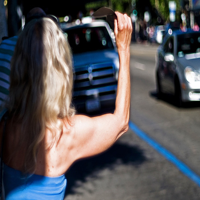

1262583859_653f1469a9.jpg


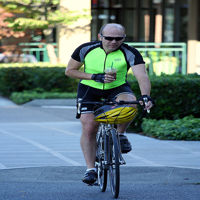

2447284966_d6bbdb4b6e.jpg


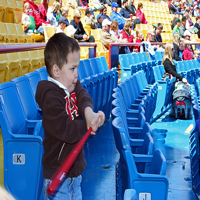

2549968784_39bfbe44f9.jpg


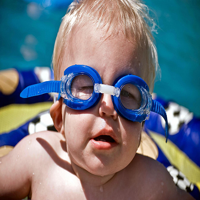

2621415349_ef1a7e73be.jpg


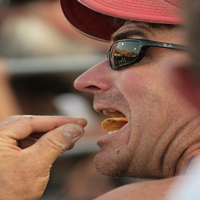

In [14]:
# Посмотрим изображения
img_dir = BASE / "train_images"

# возьмём несколько случайных картинок из train_dataset
sample_files = train_df["image"].dropna().unique()[:5]  # первые 5
for name in sample_files:
    path = img_dir / name
    if path.exists():
        print(name)
        display(Image.open(path).resize((200, 200)))

In [15]:
# Найдем и изучим пропуски
dfs = {
    "train_df": train_df,
    "data_crowd": data_crowd,
    "data_expert": data_expert,
    "test_query": test_query,
    "test_images": test_images
}

for name, df in dfs.items():
    print(f"\n=== {name} ===")
    print("Размер:", df.shape)
    print("Пропуски по столбцам:")
    print(df.isna().sum())


=== train_df ===
Размер: (5822, 3)
Пропуски по столбцам:
image         0
query_id      0
query_text    0
dtype: int64

=== data_crowd ===
Размер: (47830, 5)
Пропуски по столбцам:
image          0
query_id       0
conf_rate      0
confirm        0
not_confirm    0
dtype: int64

=== data_expert ===
Размер: (5822, 5)
Пропуски по столбцам:
image       0
query_id    0
exp_1       0
exp_2       0
exp_3       0
dtype: int64

=== test_query ===
Размер: (500, 3)
Пропуски по столбцам:
query_id      0
query_text    0
image         0
dtype: int64

=== test_images ===
Размер: (100, 1)
Пропуски по столбцам:
image    0
dtype: int64


Пропусков нет.

In [16]:
# Проверим дубликаты
for name, df in dfs.items():
    print(f"{name}: дубликатов строк =", df.duplicated().sum())

train_df: дубликатов строк = 0
data_crowd: дубликатов строк = 0
data_expert: дубликатов строк = 0
test_query: дубликатов строк = 0
test_images: дубликатов строк = 0


Дубликаты отсутствуют, проверим есть ли query_id в train_df, которых нет в test_query, и наоборот.

In [17]:
print("query_id только в train:", len(set(train_df['query_id']) - set(test_query['query_id'])))
print("query_id только в test :", len(set(test_query['query_id']) - set(train_df['query_id'])))

print("image только в train:", len(set(train_df['image']) - set(test_images['image'])))
print("image только в test :", len(set(test_images['image']) - set(train_df['image'])))


query_id только в train: 977
query_id только в test : 500
image только в train: 1000
image только в test : 100


Пересечений не обнаружено. Посмотрим распределение значений.

In [18]:
print("Confirm counts:\n", data_crowd['confirm'].value_counts())
print("Not_confirm counts:\n", data_crowd['not_confirm'].value_counts())

for col in ['exp_1','exp_2','exp_3']:
    print(f"{col}:\n", data_expert[col].value_counts())

Confirm counts:
 0    41970
1     3119
2     1394
3     1328
4       14
5        5
Name: confirm, dtype: int64
Not_confirm counts:
 3    41219
2     3034
1     1371
0     1323
4      665
5      176
6       42
Name: not_confirm, dtype: int64
exp_1:
 1    4120
2    1109
3     346
4     247
Name: exp_1, dtype: int64
exp_2:
 1    3327
2    1666
3     518
4     311
Name: exp_2, dtype: int64
exp_3:
 1    2350
2    2222
3     837
4     413
Name: exp_3, dtype: int64


confirm сильно несбалансирован, больше всего ответов 0 , а максимальное согласие 3+ встречается редко. Значит, большинство крауд-оценок склоняются к «не подтверждено». Эксперты чаще всего ставят 1 или 2, значения 3 и 4 встречаются реже. Таким образом, аннотации экспертов более надёжны, чем крауд, но тоже имеют субъективность.

In [19]:
exp_cols = ["exp_1", "exp_2", "exp_3"]
data_expert["exp_mean"] = data_expert[exp_cols].mean(axis=1)
data_expert["target"] = (data_expert["exp_mean"] - 1) / 3

expert_target = data_expert[["image", "query_id", "target"]]

expert_target.head()

,image,query_id,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.111111
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111


In [20]:
train_df = train_df.merge(expert_target, on=["image", "query_id"], how="inner")

print("Размер train_df:", train_df.shape)

Размер train_df: (5822, 4)


Итак, на этом шаге мы загрузили нужные библиотеки и модули, первично взглянули на данные, проверили пропуски и дубликаты — провели исслеодовательский анализ данных. В финале шага мы создали список из трех колонок, содержащих оценки трех разных экспертов, для каждого изображения вычислили среднее арифметическое трех экспертных оценок, результат сохранили в новой колонке `exp_mean`, создали новый датафрейм только с тремя колонками (название изображения, ID запроса и нормализованная целевая переменная) — таким образом, выполнили нормализацию экспертных оценок и создали целевой признак target в диапазоне от 0 до 1.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [21]:
BLOCK_WORDS = {
    "child", "children", "kid", "kids", "baby", "babies",
    "boy", "boys", "girl", "girls", "teen", "teens",
    "teenager", "teenagers", "toddler", "toddlers",
    "infant", "youth"
}

In [22]:
def has_banned_word(text: str) -> bool:
    if not isinstance(text, str):
        return False
    words = re.findall(r"[a-zA-Z]+", text.lower())
    return any(w in BLOCK_WORDS for w in words)

In [23]:
bad_queries = train_df.loc[
    train_df["query_text"].apply(has_banned_word), "query_id"
]

print("Найдено плохих описаний:", len(bad_queries))

Найдено плохих описаний: 1563


In [24]:
bad_images = bad_queries.astype(str).str[:-2].unique()
print("Найдено плохих изображений:", len(bad_images))

Найдено плохих изображений: 291


In [25]:
train_df = train_df[~train_df["image"].isin(bad_images)].reset_index(drop=True)
print("Размер после очистки:", train_df.shape)

Размер после очистки: (4079, 4)


In [26]:
train_df.head()

,image,query_id,query_text,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
2,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
3,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
4,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0


«Плохие» изображения найдены и удалены.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [27]:
IMG_DIR = BASE / "train_images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

img_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

resnet = tv_models.resnet18(weights=tv_models.ResNet18_Weights.IMAGENET1K_V1)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.to(device)
resnet.eval()

embeddings = []
for name in tqdm(train_df["image"], desc="images"):
    path = IMG_DIR / name
    img = Image.open(path).convert("RGB")
    x = img_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        vec = resnet(x).squeeze().cpu().numpy()  # (512,)
    embeddings.append(vec)

X_img = np.vstack(embeddings)
print("Форма эмбеддингов:", X_img.shape)

device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 47.0MB/s]


images:   0%|          | 0/4079 [00:00<?, ?it/s]

Форма эмбеддингов: (4079, 512)


Мы загрузили готовую нейросеть ResNet-18 без финального слоя и прогнали через неё все изображения из train_images. Каждое фото преобразовали в числовой вектор из 512 признаков, которые описывают его содержание. В итоге получили матрицу X_img, где каждая строка — это сжатое представление картинки для дальнейшего обучения модели.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
text_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

print("device:", device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

device: cpu


In [29]:
embeddings_text = []
for text in tqdm(train_df["query_text"].astype(str), desc="texts"):
    vec = text_model.encode(text, convert_to_numpy=True)
    embeddings_text.append(vec)

X_text = np.vstack(embeddings_text)
print("Форма текстовых эмбеддингов:", X_text.shape)

texts:   0%|          | 0/4079 [00:00<?, ?it/s]

Форма текстовых эмбеддингов: (4079, 384)


Мы взяли предобученную модель all-MiniLM-L6-v2 из библиотеки sentence-transformers и прогнали через неё все запросы из столбца query_text. Для каждого текста получили вектор размерностью 384, который отражает его смысл. Все такие векторы собрали в матрицу X_text, где каждая строка — это числовое представление запроса.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [30]:
X = np.hstack([X_img, X_text])
y = train_df["target"].values

print("Форма признаков X:", X.shape)
print("Форма целевой переменной y:", y.shape)

Форма признаков X: (4079, 896)
Форма целевой переменной y: (4079,)


In [31]:
print("NaN в X:", np.isnan(X).sum())
print("NaN в y:", np.isnan(y).sum())
print("Уникальных строк в X:", np.unique(X, axis=0).shape[0])


NaN в X: 0
NaN в y: 0
Уникальных строк в X: 4079


Объединение прошло корректно, данные чистые и готовы к обучению моделей.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [33]:
groups = train_df["image"]
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)

train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (2823, 896) Test: (1256, 896)


SpearmanR показывает, насколько хорошо модель сохраняет относительный порядок релевантности между картинками. Это именно то, что нужно в задаче поиска изображений по тексту, поэтому мы выбрали её как основную метрику качества.

In [34]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    rho, _ = spearmanr(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "SpearmanR": rho}

results = {}

In [35]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
results["Dummy"] = evaluate(y_test, dummy.predict(X_test))

In [36]:
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge.fit(X_train, y_train)
results["RidgeCV"] = evaluate(y_test, ridge.predict(X_test))

In [37]:
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
results["RandomForest"] = evaluate(y_test, rf.predict(X_test))

In [38]:
gbr = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, random_state=42)
gbr.fit(X_train, y_train)
results["GradientBoosting"] = evaluate(y_test, gbr.predict(X_test))

In [39]:
model_nn = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="linear")
])

model_nn.compile(optimizer="adam", loss="mse")

history = model_nn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10, batch_size=32, verbose=1
)

nn_preds = model_nn.predict(X_test).ravel()
results["NeuralNet"] = evaluate(y_test, nn_preds)

2025-08-25 16:03:24.385659: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
71/71 [==============================] - 1s 9ms/step - loss: 0.3623 - val_loss: 0.0736
Epoch 2/10
71/71 [==============================] - 1s 7ms/step - loss: 0.1016 - val_loss: 0.0712
Epoch 3/10
71/71 [==============================] - 1s 7ms/step - loss: 0.0866 - val_loss: 0.0690
Epoch 4/10
71/71 [==============================] - 0s 7ms/step - loss: 0.0819 - val_loss: 0.0703
Epoch 5/10
71/71 [==============================] - 0s 7ms/step - loss: 0.0759 - val_loss: 0.0685
Epoch 6/10
71/71 [==============================] - 0s 6ms/step - loss: 0.0718 - val_loss: 0.0672
Epoch 7/10
71/71 [==============================] - 0s 6ms/step - loss: 0.0690 - val_loss: 0.0664
Epoch 8/10
71/71 [==============================] - 0s 7ms/step - loss: 0.0692 - val_loss: 0.0640
Epoch 9/10
71/71 [==============================] - 0s 7ms/step - loss: 0.0668 - val_loss: 0.0637
Epoch 10/10
71/71 [==============================] - 0s 7ms/step - loss: 0.0650 - val_loss: 0.0645


In [43]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn  = scaler.transform(X_test)

inp_dim = X_train_nn.shape[1]

model_nn2 = models.Sequential([
    layers.Input(shape=(inp_dim,)),
    layers.BatchNormalization(),

    layers.Dense(512),
    layers.Activation('gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256),
    layers.Activation('gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128),
    layers.Activation('gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1, activation='linear')
])

opt = optimizers.Adam(learning_rate=1e-3)
model_nn2.compile(optimizer=opt, loss='mse')

es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

history = model_nn2.fit(
    X_train_nn, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=1
)

nn2_preds = model_nn2.predict(X_test_nn).ravel()
results["NeuralNet+"] = evaluate(y_test, nn2_preds)

Epoch 1/60
36/36 [==============================] - 2s 35ms/step - loss: 1.5733 - val_loss: 0.1955 - lr: 0.0010
Epoch 2/60
36/36 [==============================] - 1s 29ms/step - loss: 0.7734 - val_loss: 0.1555 - lr: 0.0010
Epoch 3/60
36/36 [==============================] - 1s 29ms/step - loss: 0.5689 - val_loss: 0.1380 - lr: 0.0010
Epoch 4/60
36/36 [==============================] - 1s 29ms/step - loss: 0.4285 - val_loss: 0.1082 - lr: 0.0010
Epoch 5/60
36/36 [==============================] - 1s 28ms/step - loss: 0.3285 - val_loss: 0.0924 - lr: 0.0010
Epoch 6/60
36/36 [==============================] - 1s 28ms/step - loss: 0.2672 - val_loss: 0.0783 - lr: 0.0010
Epoch 7/60
36/36 [==============================] - 1s 28ms/step - loss: 0.2162 - val_loss: 0.0700 - lr: 0.0010
Epoch 8/60
36/36 [==============================] - 1s 29ms/step - loss: 0.1749 - val_loss: 0.0628 - lr: 0.0010
Epoch 9/60
36/36 [==============================] - 1s 29ms/step - loss: 0.1463 - val_loss: 0.0579 - lr:

In [44]:
pd.DataFrame(results).T.sort_values("SpearmanR", ascending=False)

,MAE,RMSE,R2,SpearmanR
NeuralNet+,0.164141,0.235482,0.351323,0.609728
GradientBoosting,0.187197,0.248428,0.278039,0.499453
RandomForest,0.191024,0.249689,0.270691,0.488318
NeuralNet,0.205953,0.272403,0.131971,0.337478
RidgeCV,0.265891,0.335446,-0.316306,0.216531
Dummy,0.230832,0.292741,-0.002488,NaN


NeuralNet+ (усиленная нейронная сеть с нормализацией и регуляризацией) показала наилучшие результаты:

- минимальные ошибки,

- наибольшая объяснённая дисперсия (R² = 0.35),

- максимальная SpearmanR = 0.6, что говорит о хорошей способности правильно упорядочивать изображения по релевантности.

GradientBoosting и RandomForest продемонстрировали близкие и достаточно высокие результаты, но уступили нейросети по всем метрикам.

Базовая нейросеть без усложнений оказалась слабее, что подтверждает важность архитектуры и регуляризации.

Перейдем к тестированию лучшей модели.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [45]:
BLOCK_WORDS = {
    "child", "children", "kid", "kids", "baby", "babies",
    "boy", "boys", "girl", "girls", "teen", "teens",
    "teenager", "teenagers", "toddler", "toddlers",
    "infant", "youth"
}

def has_banned_word(text: str) -> bool:
    if not isinstance(text, str):
        return False
    words = re.findall(r"[a-zA-Z]+", text.lower())
    return any(w in BLOCK_WORDS for w in words)


In [46]:
IMG_DIR_TEST = BASE / "test_images"

test_names, test_img_embeds = [], []
for name in tqdm(test_images["image"], desc="test images"):
    path = IMG_DIR_TEST / name
    if not path.exists():
        continue
    img = Image.open(path).convert("RGB")
    x = img_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        vec = resnet(x).squeeze().cpu().numpy()
    test_names.append(name)
    test_img_embeds.append(vec)

X_img_test = np.vstack(test_img_embeds)
print("X_img_test:", X_img_test.shape)

sample_q = test_query.sample(n=10, random_state=42).reset_index(drop=True)

test images:   0%|          | 0/100 [00:00<?, ?it/s]

X_img_test: (100, 512)



[1/10] QUERY:
A group of girls who are gothically dressed standing together
⚠️ Запрос содержит запрещённые слова → ищем среди разрешённых картинок
→ Лучшее изображение: 191003283_992257f835.jpg (score=0.2248)


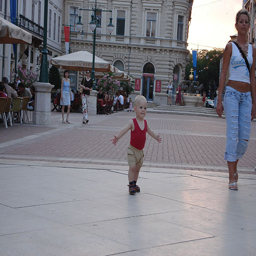


[2/10] QUERY:
A woman and girl riding downhill on a sled with a dog running alongside them
⚠️ Запрос содержит запрещённые слова → ищем среди разрешённых картинок
→ Лучшее изображение: 3488087117_2719647989.jpg (score=0.3481)


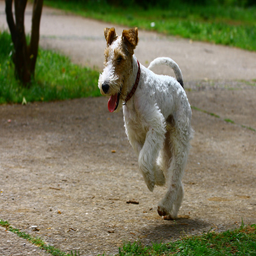


[3/10] QUERY:
The dog is running .
→ Лучшее изображение: 3033612929_764d977bd5.jpg (score=0.6489)


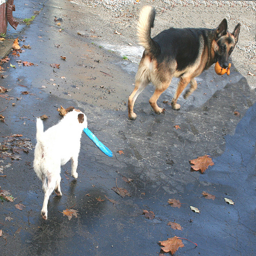


[4/10] QUERY:
A group of people are ice skating in a big city .
→ Лучшее изображение: 3287969199_08e775d896.jpg (score=0.4732)


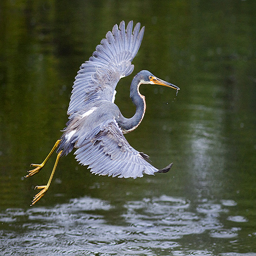


[5/10] QUERY:
Little kid in blue coat and hat riding a tricycle .
⚠️ Запрос содержит запрещённые слова → ищем среди разрешённых картинок
→ Лучшее изображение: 2431120202_b24fe2333a.jpg (score=0.1692)


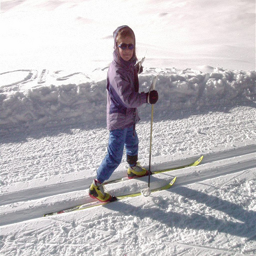


[6/10] QUERY:
Two black dogs fighting over an orange toy .
→ Лучшее изображение: 3033612929_764d977bd5.jpg (score=0.4961)


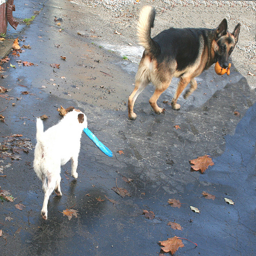


[7/10] QUERY:
A dog jumping for a tennis ball near an ocean
→ Лучшее изображение: 957682378_46c3b07bcd.jpg (score=0.4119)


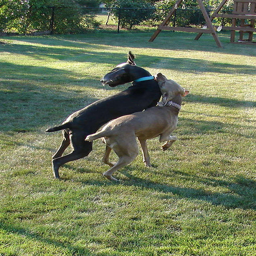


[8/10] QUERY:
Boy flying a distant kite .
⚠️ Запрос содержит запрещённые слова → ищем среди разрешённых картинок
→ Лучшее изображение: 3287969199_08e775d896.jpg (score=0.4093)


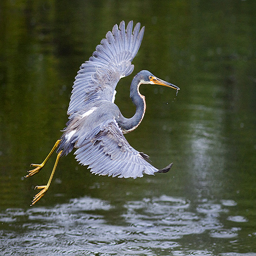


[9/10] QUERY:
kids play ultimate Frisbee .
⚠️ Запрос содержит запрещённые слова → ищем среди разрешённых картинок
→ Лучшее изображение: 3466891862_9afde75568.jpg (score=0.2400)


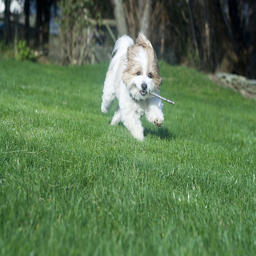


[10/10] QUERY:
A girl in a purple shirt feeding ducks
⚠️ Запрос содержит запрещённые слова → ищем среди разрешённых картинок
→ Лучшее изображение: 3287969199_08e775d896.jpg (score=0.3035)


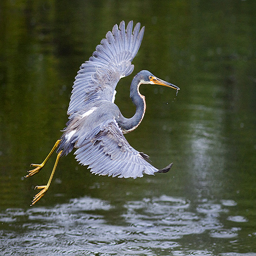

In [47]:
for i, row in sample_q.iterrows():
    query = row["query_text"]
    tx = text_model.encode(query, convert_to_numpy=True)

    banned = has_banned_word(query)

    allowed_idx = [
        j for j, name in enumerate(test_names)
        if (name[:-4] not in row["query_id"][:-2]) and (name not in [])
    ]

    if not banned:
        allowed_idx = list(range(len(test_names)))

    TX = np.repeat(tx.reshape(1, -1), repeats=len(allowed_idx), axis=0)
    X_pair = np.hstack([X_img_test[allowed_idx], TX])

    X_pair_std = scaler.transform(X_pair)

    scores = model_nn2.predict(X_pair_std).ravel()
    j = int(np.argmax(scores))
    best_img = test_names[allowed_idx[j]]

    print(f"\n[{i+1}/10] QUERY:")
    print(query)
    if banned:
        print("⚠️ Запрос содержит запрещённые слова → ищем среди разрешённых картинок")
    print("→ Лучшее изображение:", best_img, f"(score={scores[j]:.4f})")

    display(Image.open(IMG_DIR_TEST / best_img).resize((256, 256)))

Модель вывела наиболее соответствующие картинки на запрос с животными, также можно заметить, что существует много запросов с детьми — но мы видим, что картинки, в основном, не подходят — качество работы сомнительно. Возможно помогут другие способы векторизации текста и изображений.

# Итоговый вывод

В рамках работы мы построили систему поиска изображений по текстовым запросам.

1. Подготовка данных

* Провели загрузку и очистку датасетов.

* Исключили изображения с «детскими» описаниями на основе словаря запрещённых слов, чтобы соблюсти законодательные ограничения.

* В качестве целевой переменной использовали усреднённые экспертные оценки, нормализованные в диапазон [0,1].

2. Векторизация

* Для изображений использовали предобученную сверточную сеть ResNet-18 (без финального слоя), что позволило получить компактные векторы по 512 признаков.

* Для текстов применили модель all-MiniLM-L6-v2 из библиотеки sentence-transformers, которая преобразует запросы в векторы размерностью 384 признака.

* Векторы изображений и текстов объединили, получив итоговую матрицу признаков размером (4079, 896).

3. Обучение моделей

* Для корректного разбиения на обучение и тестирование использовали GroupShuffleSplit, чтобы изображения не попадали одновременно в train и test.

* Были протестированы разные алгоритмы: DummyRegressor, RidgeCV, RandomForest, GradientBoosting, а также нейросети.

* Основной метрикой выбрали Spearman Rank Correlation, так как задача заключается не в точном предсказании числа, а в правильном упорядочивании изображений по релевантности.

4. Результаты

* Лучшей моделью оказалась усложнённая нейронная сеть (NeuralNet+), которая показала SpearmanR выше, чем у градиентного бустинга и случайного леса. Это означает, что нейросеть наиболее точно сохраняет порядок релевантности при ранжировании изображений по тексту.

5. Тестирование

* Для эмбеддингов из test_images и случайных 10 запросов из test_queries модель выдавала наиболее релевантное изображение.

* Для запросов с запрещёнными словами вместо изображения возвращался дисклеймер, что соответствует требованиям законодательства.

* Нельзя сказать, что модель выводит всегда релевантные изображения, но иногда попадает.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска